# OCAT

### Importing libraries

In [303]:
import h5py
from sympy import *
import numpy as np
import pandas as pd
from copy import copy,deepcopy
import random
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import math
import sys
import os
from PIL import Image
import json
from datetime import datetime, date, time
import cellpylib as cpl
from pybdm import BDM 
plt.rcParams['animation.ffmpeg_path'] = '/usr/local/bin/ffmpeg'
plt.rcParams["animation.html"] = "jshtml"

## Helper functions

### Analysis

In [188]:
def errorMatrix1(original,test):
    size = np.shape(original)
    error = np.zeros(shape=size)
    for index in multiDimensionalGenerator(size):
        indTuple = tuple(index)
        error[indTuple] = 0 if original[indTuple] == test[indTuple] else 1
    return error

def errorMatrix2(original,test):
    size = np.shape(original)
    error = np.zeros(shape=size)
    for index in multiDimensionalGenerator(size):
        indTuple = tuple(index)
        error[indTuple] = abs(original[indTuple] - test[indTuple])
    return error

def error(errorMatrix):
    size = np.shape(errorMatrix)
    error = np.zeros(shape=size)
    summation = 0
    for index in multiDimensionalGenerator(size):
        indTuple = tuple(index)
        summation += errorMatrix[indTuple]
    return summation
        
#returns an array with the neighborhood
#expression = function to filter the neighborhood, receives a list of the indexes according to the dimension
#radious = array with the distance from each dimension                
def getNeighborhoodWLevels(radious,expression):
    neighborhood = {}
    spaces = []
    dimensions = len(radious)
    for i in range(dimensions):
        size = radious[i]
        spaces.append(np.arange(-size, size+1, 1))
    mesh = np.meshgrid(*spaces)
    stack = np.stack(mesh,axis=dimensions)
    stackShape = np.shape(stack)[:-1]
    for index in multiDimensionalGenerator(stackShape):
        tIndex = tuple(index)
        validNeighbor = expression(stack[tIndex])
        if validNeighbor[0]:
            if str(validNeighbor[1]) not in neighborhood:
                neighborhood[str(validNeighbor[1])] = []
            neighborhood[str(validNeighbor[1])].append(stack[tIndex])
    for k in neighborhood:
        for i in range(dimensions-1,-1,-1):
            neighborhood[k].sort(key = lambda x: x[i])
    return neighborhood
    
def mooreWLevels(radious):
    expr = lambda x: (True, np.max(np.array(np.abs(x))))
    neighborhood = getNeighborhoodWLevels(radious,expr)
    return neighborhood

def vonNeumannWLevels(radious,distance):
    expr = lambda x: (manhattanDistance(x) <= distance, manhattanDistance(x))
    return getNeighborhoodWLevels(radious,expr)

def getLearningProblemWLevels(data,neighborhood,paddingType,paddingValue):
    problem = {}
    dataSize = np.shape(data)
    stateSize = dataSize[1:]
    noStates = dataSize[0]
    for iState in range(1,noStates):
        currentState = data[iState-1].reshape(-1)
        for cell in multiDimensionalGenerator(stateSize):
            index = tuple([iState]+cell)
            cls = data[index]
            if cls not in problem:
                problem[cls] = {}
            values = {}
            for level in neighborhood:
                values[level] = []
                for neigh in neighborhood[level]:
                    if type(neigh) != list:
                        neighbors = getNeighbors(cell,[neigh],stateSize)
                    values[level].append({str(neigh): getNeighborsValue(currentState,neighbors,paddingType,paddingValue)[0] })
                    #values[level] = [values[level][key] for key in values[level]]
            problem[cls][str(values)] = values
    return problem

def information(problemWLevels,nlevels):
    info = {}
    for cls in problemWLevels:
        for level in range(nlevels):
            for key in problemWLevels[cls]:
                info[cls][level]
                
def getStr(levels,nlevels):
    res = {}
    middle = list(levels['0'][0].values())
    for i in range(1,nlevels+1): 
        i = str(i)
        left = levels[i][:(int)(len(levels[i])/2)]
        right = levels[i][(int)(len(levels[i])/2):]
        tmpleft = []
        tmpright = []
        for x in left:
            tmpleft += list(x.values())
        for x in right:
            tmpright += list(x.values())
        middle = tmpleft+copy(middle)+tmpright
        res[i] = middle
    return res

def strLevel(problem,nlevels):
    res = {}
    for cls in problem:
        res[cls] = {}
        for k in problem[cls]:
            temp = getStr(problem[cls][k],nlevels)
            for l in temp:
                if l not in res[cls]:
                    res[cls][l] = {}
                strtemp = str(temp[l])
                if strtemp not in res[cls][l]:
                    res[cls][l][strtemp] = ["",0]
                res[cls][l][strtemp][0] = temp[l]
                res[cls][l][strtemp][1] += 1 
    return res
    
def getTable(strlevels):
    tbl = {}
    for cls in strlevels:
        tbl[cls] = {}
        for lvl in strlevels[cls]:
            tbl[cls][lvl] = []
            for itm in strlevels[cls][lvl]:
                tbl[cls][lvl].append( strlevels[cls][lvl][itm])
            tbl[cls][lvl] = sorted(tbl[cls][lvl],key = lambda x:x[1],reverse = True)
    return tbl

def getTopFrequent(levels,top=10):
    mostFrequent = {}
    for cls in levels:
        mostFrequent[cls] = {}
        for lvl in levels[cls]:
            mostFrequent[cls][lvl] = levels[cls][lvl][:top]
    return mostFrequent

def getUniqueCount(levels):
    uniques = {}
    for cls in levels:
        uniques[cls] = {}
        for lvl in levels[cls]:
            uniques[cls][lvl] = 0
            for item in levels[cls][lvl]:
                if item[1] == 1:
                    uniques[cls][lvl] += 1
    return uniques

def getLevelClass(levels):
    res = {}
    for cls in levels:
        for lvl in levels[cls]:
            if lvl not in res:
                res[lvl] = {}
            for item in levels[cls][lvl]:
                itemstr = str(item[0])
                if itemstr not in res[lvl]:
                    res[lvl][itemstr] = {}
                if cls not in res[lvl][itemstr]:
                    res[lvl][itemstr][cls] = 0
                res[lvl][itemstr][cls] += item[1]
    return res


def getNeighborhoodAmbiguity(levels):
    ambiguity = {}
    for lvl in levels:
        ambiguity[lvl] = {}
        for item in levels[lvl]:
            if len(levels[lvl][item].keys()) > 1:
                ambiguity[lvl][item] = levels[lvl][item]
    return ambiguity

def getFrequencyByLocation(levels,nlstlevel):
    frequency = {}
    for cls in levels:
        frequency[cls] = {}
        for item in levels[cls][str(nlstlevel)]:
            for i,v in enumerate(item[0]):
                if i not in frequency[cls]:
                    frequency[cls][i] = {}
                if v not in frequency[cls][i]:
                    frequency[cls][i][v] = 0
                frequency[cls][i][v] += item[1]
    return frequency


def normalizeFrequency(frequency):
    normalized = {}
    for cls in frequency:
        normalized[cls] = {}
        for ind in frequency[cls]:
            normalized[cls][ind] = {}
            total = 0
            for v in frequency[cls][ind]:
                total += frequency[cls][ind][v]
            for v in frequency[cls][ind]:
                normalized[cls][ind][v] = frequency[cls][ind][v]/total
    return normalized

def getBDM(levels):
    bdm = BDM(ndim=1, nsymbols=4,raise_if_zero=False)
    res = {}
    for cls in levels:
        res[cls] = {}
        for lvl in levels[cls]:
            res[cls][lvl] = []
            for item in levels[cls][lvl]:
                tmp = np.array(item[0],dtype="int")
                #print(len(tmp))
                nbdm = 0
                try:
                    nbdm = bdm.nbdm(tmp)
                except:
                    nbdm = 0
                res[cls][lvl].append([item[0], nbdm])
            res[cls][lvl] = sorted(res[cls][lvl],key= lambda x: x[1],reverse = True)     
    return res

def getPlotFrequencies(frequencies):
    clsvals = {}
    ind = list(frequencies.keys())
    clss = list(frequencies.keys())
    for cls2 in clss:
        ind = list(frequencies[cls2].keys())
        clsvals[cls2] = {}
        for i in ind:
            for cls in clss:
                if cls not in clsvals[cls2]:
                    clsvals[cls2][cls] = []
                if cls not in frequencies[cls2][i]:
                    clsvals[cls2][cls].append(0)
                else:
                    clsvals[cls2][cls].append(frequencies[cls2][i][cls])
    for cls2 in clss:
        ind = list(frequencies[cls2].keys())
        bottoms = None
        bars = []
        subplt = plt.figure(figsize=(15,5))
        for cls in clsvals[cls2]:
            if bottoms is None:
                tmp = plt.bar(ind, clsvals[cls2][cls])
                bottoms = clsvals[cls2][cls]
            else:
                tmp = plt.bar(ind, clsvals[cls2][cls],bottom=bottoms)
                bottoms = np.sum([bottoms,clsvals[cls2][cls]],axis=0)
            bars.append(tmp)
        plt.title(cls2)
        plt.xticks(ind, ind)
        plt.legend(bars, [str(x) for x in list(clsvals[cls2].keys())])
        plt.show()

### Visualization

In [37]:
def plotCA(data,size=(20,10),display=True):
    fig, ax = plt.subplots(figsize=size)
    im = ax.imshow(data,plt.cm.Greys)
    plt.ylabel("steps",fontsize="large")
    for i in range(len(data)):
        for j in range(len(data[i])):
            c = "w"
            if data[i][j] <= 2:
                c = "black"
            text = ax.text(j, i, data[i][j],
                           ha="center", va="center", color=c,fontsize="large")
    if display:
        plt.show()
        return None
    return fig

def animate(data,cmap = "Set1",size=(20,10)):
    n_frames = len(data)

    dims = np.shape(data)
    colorsData = np.zeros(dims)
    for i in range(min(dims)):
        colorsData[i, i] = i
    fig = plt.figure(figsize=size)
    plot = plt.matshow(data[len(data)-1], fignum=0,cmap=cmap)

    def init():
        plot.set_data(data[0])
        return [plot]

    def update(j):
        plot.set_data(data[j])
        return [plot]


    anim = animation.FuncAnimation(fig, update, init_func = init, frames=n_frames, interval = 30, blit=True)

    return anim

### General

In [130]:
def encodeKey(index,value):
    return "{},{}".format(index,value)

def decodeKey(key):
    return list(map(lambda x: int(x),key.split(",")))

#returns an expression to get the transformed coordinates 
# from the original dimensions to the 1 dimension flattened data
def getExpr(size):
    val = ""
    lst = []
    if len(size) > 1:
        for i in range(1,len(size)):
            temp = "xi[{}]".format(i-1)
            for j in range(i,len(size)):
                temp += "*{}".format(size[j])
            lst.append(temp)
    else:
        i = 0
    val += "+".join(lst)
    val += "+xi[{}]".format(i)
    return val


#returns an array with the position in the flattened data
#coords is an array with coordinate relative to the cell in the original dimensions
# size = np.shape(data)
def getNeighbors(cell,coords,size):
    newCoords = []
    expr = getExpr(size)
    for coord in coords:
        xi = []
        outOfBounds = False
        for i,c in enumerate(cell):
            if type(coord) != int:
                v = c+coord[i]
                if v >= size[i] or v < 0:
                    outOfBounds = True
                else:
                    xi.append(v)
            else:
                v = c+coord
                if v >= size[0] or v < 0:
                    outOfBounds = True
                else:
                    xi.append(c+coord)
        if outOfBounds:
            newCoords.append(-1)
        else:
            newCoord = eval(expr)
            newCoords.append(newCoord)
            
    return newCoords

#returns the values of the neighbors of a certain cell
#data = flattened array of the data
#neighbors = the positions of neighbors of a certain cell
#paddingtype = 0 => don't get values,1=> fill with padding value, 2 => don't fill and return empty dict
#paddingvalue = the values to fill when the padding type equals 1
def getNeighborsValue(data,neighbors,paddingType = 0,paddingValue=0):
    values = {}
    for i,n in enumerate(neighbors):
        val = None
        if n >= 0 and n < len(data):
            val = data[n]
        else:
            if paddingType == 0: continue
            elif paddingType == 1:
                val = paddingValue
            elif paddingType == 2:
                values = None
                break
        if val != None:
            values[i] = val
    return values

#returns in each iteration an array with the indexes of each dimension
def multiDimensionalGenerator(size):
    counters = np.array([size[i]-1 for i in range(len(size)-1)])
    counters = np.append(counters,size[-1])
    count = len(size)-1
    while (counters[0] >= 0):
        counters[count] -= 1
        yield [int(i) for i in counters]
        if counters[count] <= 0:
            while(counters[count] <= 0 and count > 0):
                count -= 1
            counters[count] -= 1 
            while(count+1 < len(size)):
                if count+1 == len(size)-1:
                    counters[count+1] = size[count+1]
                else:
                    counters[count+1] = size[count+1]-1
                count += 1

def manhattanDistance(arr):
    res = 0
    for i in arr:
        res += abs(i)
    return res
    
def vonNeumann(radious,distance):
    expr = lambda x: manhattanDistance(x) <= distance
    return getNeighborhood(radious,expr)
    
                
def moore(radious):
    expr = lambda x: True
    neighborhood = getNeighborhood(radious,expr)
    return neighborhood

#returns an array with the neighborhood
#expression = function to filter the neighborhood, receives a list of the indexes according to the dimension
#radious = array with the distance from each dimension                
def getNeighborhood(radious,expression):
    neighborhood = []
    spaces = []
    dimensions = len(radious)
    for i in range(dimensions):
        size = radious[i]
        spaces.append(np.arange(-size, size+1, 1))
    mesh = np.meshgrid(*spaces)
    stack = np.stack(mesh,axis=dimensions)
    stackShape = np.shape(stack)[:-1]
    for index in multiDimensionalGenerator(stackShape):
        tIndex = tuple(index)
        if expression(stack[tIndex]):
            neighborhood.append(stack[tIndex])
    for i in range(dimensions-1,-1,-1):
        neighborhood.sort(key = lambda x: x[i])
    return neighborhood

### Preprocessing

In [39]:
def dictToMat(dic):
    matrix = []
    for key in dic:
        for key2 in dic[key]:
            temp = copy(dic[key][key2])
            if type(temp) == np.ndarray:
                temp = np.append(temp,key)
            else:
                temp.append(key)
            matrix.append(temp)
    return matrix

def getDomain(data):
    #encontramos los valores observados de cada atributo en los subproblemas de aprendizaje
    domain = {}
    for row in data:
        for j,col in enumerate(row):
            if j not in domain:
                domain[j] = []
            if col not in domain[j]:
                domain[j].append(col)
    for key in domain:
        domain[key].sort()
    return domain

def binarize(data,domain):
    #binarizamos los subproblemas de aprendizaje
    binarizedMatrix = []
    for row in data:
        rtemp = []
        for j,col in enumerate(row):
            if j < len(row)-1:
                for val in domain[j]:
                    if col >= val:
                        rtemp.append(1)
                    else:
                        rtemp.append(0)
            else:
                rtemp.append(col)
        binarizedMatrix.append(rtemp)
    return binarizedMatrix

def getPosNeg(domain,binarized):
    # obtenemos los ejemplos positivos y negativos para el atributo x[1] de los subproblemas
    keys = list(domain.keys())
    pos_neg = {}
    pos = {}
    for row in binarized:
        for val in domain[keys[-1]]:
            if val not in pos_neg:
                pos_neg[val] = {"pos":[],"neg":[]}
            if val not in pos:
                pos[val] = {}
            temp = "".join(map(str,row[:-1]))
            if val == row[-1]:
                if temp not in pos[val]:
                    pos_neg[val]["pos"].append(row[:-1])
                    pos[val][temp] = 0 
            else:
                if temp not in pos[val]:
                    pos_neg[val]["neg"].append(row[:-1])
                    pos[val][temp] = 0 
    return pos_neg

def getLearningProblem(data,neighborhood,paddingType,paddingValue):
    problem = {}
    dataSize = np.shape(data)
    stateSize = dataSize[1:]
    noStates = dataSize[0]
    for iState in range(1,noStates):
        currentState = data[iState-1].reshape(-1)
        for cell in multiDimensionalGenerator(stateSize):
            index = tuple([iState]+cell)
            cls = data[index]
            if cls not in problem:
                problem[cls] = {}
            neighbors = getNeighbors(cell,neighborhood,stateSize)
            values = getNeighborsValue(currentState,neighbors,paddingType,paddingValue)
            values = [values[key] for key in values]
            problem[cls][str(values)] = values
    return problem


In [ ]:
def dictToMat2(dic):
    matrix = {}
    for key in dic:
        matrix[key] = []
        for key2 in dic[key]:
            for key3 in dic[key][key2]:
                temp = copy(dic[key][key2][key3])
                if type(temp) == np.ndarray:
                    temp = np.append(temp,key2)
                else:
                    temp.append(key2)
                matrix[key].append(temp)
    return matrix

def getLearningProblem2(data,neighborhood,paddingType,paddingValue):
    problem = {}
    dataSize = np.shape(data)
    stateSize = dataSize[1:]
    noStates = dataSize[0]
    for iState in range(1,noStates):
        currentState = data[iState-1].reshape(-1)
        for cell in multiDimensionalGenerator(stateSize):
            indKey = "{}".format(cell)
            if indKey not in problem:
                problem[indKey] = {}
            index = tuple([iState]+cell)
            cls = data[index]
            if cls not in problem[indKey]:
                problem[indKey][cls] = {}
            neighbors = getNeighbors(cell,neighborhood,stateSize)
            values = getNeighborsValue(currentState,neighbors,paddingType,paddingValue)
            values = [values[key] for key in values]
            problem[indKey][cls][str(values)] = values
    return problem

### OCAT-RA1

In [ ]:
def fitness(negativeExamples,positiveExamples,removedNegativeExamples,removedPositiveExamples,removedTerms):
    shape = np.shape(positiveExamples)
    terms = getTerms(shape[1],removedTerms)
    positiveCounts = getCounts(positiveExamples,removedPositiveExamples,terms)
    negativeCounts = getCounts(negativeExamples,removedNegativeExamples,terms)
    score = []
    for term in terms:
        if negativeCounts[term] == 0 and positiveCounts[term] > 0:
            score.append([term,positiveCounts[term]*100])
        elif negativeCounts[term] > 0:
            score.append([term,positiveCounts[term]/negativeCounts[term]])
    score.sort(key=lambda x: x[1], reverse=True)
    return score

def getTerms(size,removedTerms):
    terms = []
    domain = [0,1] #this is the domain because is binarized
    for i in range(size):
        for j in domain:
            if (i in removedTerms) and (j in removedTerms[i]):
                continue
            else:
                term = encodeKey(i,j)
                terms.append(term)
    return terms

def getCounts(examples,removed,terms):
    counts = {}
    for term in terms:
        counts[term] = 0
    for i,example in enumerate(examples):
        if i not in removed:
            for term in terms:
                index,value = decodeKey(term)
                counts[term] += (1 if example[index] == value else 0)
    return counts

#returns the top 10 best
def filterTop(score,k):
    filtered = score[:k]
    return filtered

#returns the best scores with no more than percentage of difference from the maximum
def filterBest(score,percentage):
    mx = score[0][1]
    temp = mx * percentage
    filtered = list(filter(lambda x: x[1] >= temp ,score))
    return filtered

def removePositiveExamples(examples,removed,term):
    index,value = decodeKey(term)
    for i,example in enumerate(examples):
        if i not in removed:
            if example[index] == value:
                removed.add(i)

def removeNegativeExamples(examples,removed,clausule):
    for i,example in enumerate(examples):
        if i not in removed:
            remove = True
            for term in clausule:
                index,value = term
                remove = remove and (example[index] != value)
            if remove:
                removed.add(i)

def addRemovedAttribute(i,removedTerms):
    domain = [0,1]
    if i not in removedTerms:
        removedTerms[i] = set()
    for val in domain:
        removedTerms[i].add(val)

def clausuleToString(clausule):
    terms = []
    for term in clausule:
        terms.append(",".join([str(x) for x in term]))
    return "-".join(terms)

def decodeClausules(clausules):
    decoded = []
    for clausule in clausules:
        decoded.append(clausule.split("-"))
    return decoded

def ocat(data,seed=-1,percentage = -1, top = -1):
    negativeExamples = data["neg"]
    positiveExamples = data["pos"]
    clausules = set()
    removedNegativeExamples = set()
    if (seed != -1):
        random.seed(seed)
    while (len(negativeExamples) > len(removedNegativeExamples)):
        clausule = []
        removedPositiveExamples = set()
        removedTerms = {}
        while (len(positiveExamples) > len(removedPositiveExamples)):
            score = fitness(negativeExamples,positiveExamples,removedNegativeExamples,removedPositiveExamples,removedTerms)
            if percentage > 0:
                score = filterBest(score,percentage)
            elif top > 0:
                score = filterTop(score,top)
            selectedIndex = random.randint(0,len(score)-1)
            best = score[selectedIndex]
            index,value = decodeKey(best[0])
            addRemovedAttribute(index,removedTerms)
            removePositiveExamples(positiveExamples,removedPositiveExamples,best[0])
            clausule.append([index,value])
        clausule.sort(key= lambda x: x[0])
        clausules.add(clausuleToString(clausule))
        removeNegativeExamples(negativeExamples,removedNegativeExamples,clausule)
            
    return decodeClausules(clausules)

def getRules(posNeg,percentage=-1,top=-1,stopAfter=50,seed = -1):
    rules = {}
    for key in posNeg:
        if key not in rules:
            rules[key] = {}
        if len(posNeg[key]["pos"]) > 0 and len(posNeg[key]["neg"]) > 0:
            print("learning op ",key)
            rule = ocat(posNeg[key],seed,percentage,top)
            if rule == None:
                return None
            rules[key] = rule
    return rules


### GA-Nuggets

In [517]:
#individual format (ant,cons) where:
# ant = [[attrInd,val],...,[attrInd,val]]
# cons = [attrInd,val]

#Returns the number of active attributes in the antecedent
def getNumberOfAttributes(ant):
    count = 0;
    for attr in ant:
        if attr[1] != -1:
            count += 1
    return count

#Returns the interestingess degree 
#totalInfoGain = the summatory of the infoGain for each attribute in the antecedent
#noOfAttr = the number of attributes in the antecedent
#domainCardinality = the Cardinality of the goal attribute
def antInterestignessDegree(totalInfoGain,noOfAttr,domainCardinality):
    if (noOfAttr == 0 ):
        return 1
    return 1 - ((totalInfoGain/noOfAttr)/math.log2(domainCardinality))


def consInterestignessDegree(consAttr,noEvents,beta):
    noFavEvents = noEvents[consAttr[0]][consAttr[0]][consAttr[1]][consAttr[1]]
    totalNoEvents = noEvents["totalNoEvents"]
    return math.pow( 1 -  probability(noFavEvents,totalNoEvents),(1/beta) )

#returns the infoGain of an antecedent attribute with a given goal attribute
#attAnt = the antecedent attribute (pair of attr index and value)
#attCons = the consequent attribute (pair of attr index and value)
#domain = the domain of the attributes
#noEvents = tha total number of events for the probability calculation
def infoGain(attAnt,attCons,domain,noEvents):
    #print("---",info(domain,noEvents,attCons),info(domain,noEvents,attCons,attAnt),"----")
    return info(domain,noEvents,attCons) - info(domain,noEvents,attCons,attAnt)

#returns the entropy of the goal attribute or the entropy ot he goal attribute given antecedent attribute
#domain = the domain of the attributes
#noEvents = tha total number of events for the probability calculation
#attCons = the consequent attribute (pair of attr index and value)
#attAnt = the antecedent attribute (pair of attr index and value)
def info(domain,noEvents,attCons,attAnt = None):
    res = 0
    if attAnt == None:
        for val in domain[attCons[0]]:
            noFavEvents = noEvents[attCons[0]][attCons[0]][val][val]
            totalNoEvents = noEvents["totalNoEvents"]
            pr = probability(noFavEvents,totalNoEvents)
            res += (pr*math.log2(pr))
        res = res * -1
    else:
        for val in domain[attAnt[0]]:
            totalNoEvents = noEvents["totalNoEvents"]
            noFavEvents = 0
            for gAttr in noEvents[attAnt[0]]:
                for gVal in noEvents[attAnt[0]][gAttr]:
                    noFavEvents += noEvents[attAnt[0]][gAttr][gVal][val]
            prAntAtt = probability(noFavEvents,totalNoEvents)
            sumCondInfo = 0
            for cVal in domain[attCons[0]]:
                probCA = probability(noEvents[attAnt[0]][attCons[0]][cVal][val],totalNoEvents)
                probA = probability(noFavEvents,totalNoEvents)
                condProb = probCA / probA
                if (condProb>0):
                    sumCondInfo += (condProb*math.log2(condProb))
            sumCondInfo *= -1
            res += sumCondInfo * prAntAtt
    return res
            

def probability(noFavEvents,noEvents):
    return noFavEvents/noEvents

#Calculate the number of events given each possible value of the goal attributes indexes specified
#goalAttributes = an array with the goal attributes
#domain = the domain of the attributes
#dataset = the dataset where the data that will be processed
def calculateNoEvents(goalAttributes,domain,dataset):
    noEventsC = {}
    noEvents = 1
    #for step in dataset:
    #    noEvents += len(step)
    for val in np.shape(dataset)[:-1]:
        noEvents = noEvents*val
    
    for attr in domain:
        noEventsC[attr] = {}
        for g in goalAttributes:
            noEventsC[attr][g] = {}
            for gval in domain[g]:
                noEventsC[attr][g][gval] = {}
                for val in domain[attr]:
                    noEventsC[attr][g][gval][val] = 0
    
    size = np.shape(dataset)
    for index in multiDimensionalGenerator(size):
        ind = tuple(index)
        val = dataset[ind]
        attr = index[-1]
        for g in goalAttributes:
            ind2 = tuple(index[:-1]+[g])
            gval = dataset[ind2]
            noEventsC[attr][g][gval][val] += 1
    noEventsC["totalNoEvents"] = noEvents
    return noEventsC
        
#Returns the accuracy of the antecedent with the consequent
#ant = the array of attributes
#cons =  the attribute
#dataset = the data that will be processed
def predictionAccuracy(ant,cons,dataset):
    acCount = {}
    aCount = 0
    size = np.shape(dataset)[:-1]
    for index in multiDimensionalGenerator(size):
        ind = tuple(index)
        vAnt = True
        row = dataset[ind]
        for att in ant:
            vAnt = vAnt and ((row[att[0]] == att[1]) if att[1] != -1 else True)
        if row[cons[0]] not in acCount:
            acCount[row[cons[0]]] = 0
        if vAnt:
            acCount[row[cons[0]]] += 1
            aCount += 1
    for key in acCount:
        if aCount > 0:
            acCount[key] = (acCount[key] - 1/2)/aCount
    return acCount

def predictionAccuracy2(ant,cons,dataset):
    acCount = {"accepted":{},"rejected":{}}
    aCount = 0
    size = np.shape(dataset)[:-1]
    for index in multiDimensionalGenerator(size):
        ind = tuple(index)
        vAnt = True
        row = dataset[ind]
        for att in ant:
            vAnt = vAnt and ((row[att[0]] == att[1]) if att[1] != -1 else True)
        if row[cons[0]] not in acCount["accepted"]:
            acCount["accepted"][row[cons[0]]] = 0
        if row[cons[0]] not in acCount["rejected"]:
            acCount["rejected"][row[cons[0]]] = 0
        if vAnt:
            acCount["accepted"][row[cons[0]]] += 1
            aCount += 1
        else:
            acCount["rejected"][row[cons[0]]] += 1
    return acCount

def f1score(acc):
    recall = {}
    precision = {}
    f1 = {}
    for key in acc["accepted"]:
        recall[key] = acc["accepted"][key]
        precision[key] = acc["accepted"][key]
        f1[key] = 0
        for key2 in acc["rejected"]:
            if key == key2:
                recall[key] += acc["rejected"][key]
        for key2 in acc["accepted"]:
            if key != key2:
                precision[key] += acc["accepted"][key2]
        recall[key] = acc["accepted"][key] / recall[key]
        precision[key] = (acc["accepted"][key] / precision[key]) if precision[key] != 0 else 0
        if (precision[key] + recall[key]) != 0:
            f1[key] = recall[key] * precision[key] / (precision[key] + recall[key])
        else:
            f1[key] = 0
    return f1
    

#Returns the fitnes of an individual
def gafitness(w1,w2,beta,ant,cons,domain,noEvents,dataset):
    bestGoalValue = 0
    noAttr = 0
    noAttr = getNumberOfAttributes(ant)
    consInt = {}
    sumInfoGain= {}
    antInt = {}
    acc = predictionAccuracy2(ant,cons,dataset)
    acc = f1score(acc)
    #print(acc)
    for val in domain[cons[0]]:
        consInt[val] = consInterestignessDegree([cons[0],val],noEvents,beta)
        if val not in sumInfoGain:
            sumInfoGain[val] = 0
        for attr in ant:
            if attr[1] != -1:
                sumInfoGain[val] += infoGain(attr,[cons[0],val],domain,noEvents)
        antInt[val] = antInterestignessDegree(sumInfoGain[val],noAttr,len(domain[cons[0]]))
        fit = ((w1*(antInt[val] + consInt[val]) / 2) + (w2 * acc[val])) / (w1 + w2)
        #print("fit {},antInt {},consInt {},acc {}".format(fit,antInt[val],consInt[val],acc[val]))
        #print(fit)
        
        if fit > bestGoalValue:
            bestGoalValue = fit
            cons[1] = val
    return bestGoalValue

def initialize(populationSize,antMinSize,antMaxSize,objAttrInd,domain,seed=-1):
    population = []
    if seed != -1:
        random.seed(seed)
    for i in range(populationSize):
        antSize = random.randint(antMinSize,antMaxSize)
        ant = [[i,-1] for i in range(len(domain))]
        for j in range(antSize):
            attr = random.randint(0,len(domain)-1)
            val = random.randint(-1,max(domain[attr]))
            ant[attr][1]= val
        valC = random.randint(min(domain[objAttrInd]),max(domain[objAttrInd]))
        cons = [objAttrInd,valC]
        population.append([ant,cons])
    return population

def countActiveGenes(ant):
    count = 0
    for gen in ant:
        if gen[1] != -1:
            count += 1
    return count

def insertCondition(ant,antMaxSize,domain):
    active = countActiveGenes(ant)
    prob = 1-(active/antMaxSize)
    if random.random() < prob:
        for gen in ant:
            if random.random() < .2 and active < antMaxSize:
                if gen[1] == -1:
                    ind = random.randint(0,len(domain[gen[0]])-1)
                    gen[1] = domain[gen[0]][ind]
                    active += 1
                    prob = 1-(active/antMaxSize)

def removeCondition(ant,antMaxSize,domain):
    active = countActiveGenes(ant)
    prob = (active/antMaxSize)
    if random.random() < prob: 
        for gen in ant:
            if active > 1:
                if random.random() < .2:
                    if gen[1] != -1:
                        gen[1] = -1
                        active -= 1
                        prob = (active/antMaxSize)

def tournament(fitnessTbl,k):
    best = None
    for i in range(k+1):
        ind = random.randint(0, len(fitnessTbl)-1)
        if (best == None) or fitnessTbl[ind][1] > fitnessTbl[best][1]:
            best = ind
    return fitnessTbl[best]

def crossover(parents,population,crossprob):
    offsprings = []
    for i in range(1,len(parents),2):
        p1 = population[parents[i-1][0]][0]
        p2 = population[parents[i][0]][0]
        child1 = [[],[population[parents[i-1][0]][1][0],population[parents[i-1][0]][1][1]]]
        child2 = [[],[population[parents[i][0]][1][0],population[parents[i][0]][1][1]]]
        for j in range(len(p1)):
            if random.random() < crossprob:
                child1[0].append([p2[j][0],p2[j][1]])
                child2[0].append([p1[j][0],p1[j][1]])
            else:
                child1[0].append([p1[j][0],p1[j][1]])
                child2[0].append([p2[j][0],p2[j][1]])
        offsprings.append(child1)
        offsprings.append(child2)
    return offsprings

def mutate(ant,domain,mutationRate):
    for gen in ant:
        if random.random() <= mutationRate:
            ind = random.randint(0,len(domain[gen[0]])-1)
            gen[1] = domain[gen[0]][ind]

def removePopulation(population,fitnessTbl,populationSize):
    newPopulation = []
    newPopulation = [population[fitnessTbl[0][0]] ]#for x in fitnessTbl[:populationSize]]
    for i in range(populationSize):
        elite = tournament(fitnessTbl,2)
        newPopulation.append(population[elite[0]])
        fitnessTbl.remove(elite)
        if len(fitnessTbl) <= 0: break
    return newPopulation
    
def ganuggets(populationSize,noOffsprings,antMinSize,antMaxSize,beta,w1,w2,mutationRate,crossprob,dataset,domain,goalAttr,noEvents,seed,maxIter = 0):
    population = initialize(populationSize,antMinSize,antMaxSize,goalAttr,domain,seed)
    fitnessTbl = []
    for i in range(len(population)):
        fit = gafitness(w1,w2,beta,population[i][0],population[i][1],domain,noEvents,dataset)
        fitnessTbl.append([i,fit,population[i][1][1]])
    it = 0
    fitGoalReached = False
    fitnessHistory = {}
    while it < maxIter and not fitGoalReached:
        print(it)
        it += 1
        fitnessTbl = sorted(fitnessTbl,key = lambda x: x[1],reverse = True)
        
        #select individuals based on fitness
        groupedFitness = {}
        for fit in fitnessTbl:
            if fit[2] not in groupedFitness:
                groupedFitness[fit[2]] = []
            if fit[2] not in fitnessHistory:
                fitnessHistory[fit[2]] = []
            groupedFitness[fit[2]].append(fit)
        parents = {}
        offsprings = []
        for key in groupedFitness:
            if len(groupedFitness[key]) > 0:
                #print("1.- ",groupedFitness[key][0])
                fitnessHistory[key].append(groupedFitness[key][0][1])
                if key not in parents:
                    parents[key] = []
                for i in range(noOffsprings*2):
                    best = tournament(groupedFitness[key],2)
                    parents[key].append(best)
                offsprings += crossover(parents[key],population,crossprob)
                
        for child in offsprings:
            mutate(child[0],domain,mutationRate)
            insertCondition(child[0],antMaxSize,domain)
            removeCondition(child[0],antMaxSize,domain)
        population = population+offsprings
        fitnessTbl = []
        for i in range(len(population)):
            fit = gafitness(w1,w2,beta,population[i][0],population[i][1],domain,noEvents,dataset)
            fitnessTbl.append([i,fit,population[i][1][1]])
        fitnessTbl = sorted(fitnessTbl,key = lambda x: x[1],reverse = True)
        groupedFitness = {}
        for fit in fitnessTbl:
            if fit[2] not in groupedFitness:
                groupedFitness[fit[2]] = []
            groupedFitness[fit[2]].append(fit)
        temPop = []
        for key in groupedFitness:
            #print("2.- ",groupedFitness[key][0])
            if len(groupedFitness[key]) > 0:
                temPop += removePopulation(population,groupedFitness[key],populationSize)
        population = temPop
        fitnessTbl = []
        for i in range(len(population)):
            fit = gafitness(w1,w2,beta,population[i][0],population[i][1],domain,noEvents,dataset)
            fitnessTbl.append([i,fit,population[i][1][1]])
    fitnessTbl = sorted(fitnessTbl,key = lambda x: x[1],reverse = True)
    return fitnessTbl,population,fitnessHistory

### Algorithm proposal

In [508]:
class GAModel():
    def __init__(self,populationSize,antMinSize,antMaxSize,objAttrInd,domain,seed=-1):
        self.populationSize = populationSize
        self.antMinSize = antMinSize
        self.antMaxSize = antMaxSize
        self.objAttrInd = objAttrInd
        self.domain = domain
        self.seed = seed
        
    def initialize(self):
        population = []
        for i in range(self.populationSize):
            antSize = random.randint(self.antMinSize,self.antMaxSize)
            ant = [[i,-1] for i in range(len(self.domain)-1)]
            for j in range(antSize):
                attr = random.randint(0,len(self.domain)-1)
                val = random.randint(-1,max(self.domain[attr]))
                ant[j]= [attr,val]
            valC = random.randint(min(self.domain[objAttrInd]),max(self.domain[objAttrInd]))
            cons = [objAttrInd,valC]
            population.append([ant,cons])
        return population
    
    def run(self):
        if self.seed != -1:
            random.seed(self.seed)
        population = self.initialize()

### Rule simplification

In [510]:
def firstSimplification(rules,domain):
    keys = list(domain.keys())
    oRules = {}
    for cls in rules:
        if cls not in oRules:
            oRules[cls] = {}
        prop = []
        for clause in rules[cls]:
            expr = {}
            for term in clause:
                col = 0
                ind,val = decodeKey(term)
                bottom = 0
                for key in keys:
                    if ind >= bottom and ind < (bottom + len(domain[key])):
                        col = key
                        ind -= bottom
                        break
                    bottom += len(domain[key])
                relational = (">=" if val== 1 else "<")
                if col not in expr:
                    expr[col] = {}
                if relational not in expr[col]:
                    expr[col][relational] = None
                if val == 1:
                    if expr[col][relational] == None:
                        expr[col][relational] = sys.maxsize
                    expr[col][relational] = min(expr[col][relational],domain[col][ind])
                else:
                    if expr[col][relational] == None:
                        expr[col][relational] = -sys.maxsize
                    expr[col][relational] = max(expr[col][relational],domain[col][ind])
            expr2 = []
            for col in expr:
                if len(expr[col]) == 2:
                    if expr[col][">="]-1 == expr[col]["<"]:
                        expr[col]["!="] = expr[col]["<"]
                        del expr[col][">="]
                        del expr[col]["<"]
            for col in expr:
                for rel in expr[col]:
                    t = "A[{}] {} {}".format(col,rel,expr[col][rel])
                    expr2.append(t)
            prop.append("({})".format(" or ".join(expr2)))
        oRules[cls] = " and ".join(prop)
    return oRules

def getLiterals(oRules):
    literals = {}
    literalsInv = {}
    count = 0
    for key in oRules:
        sel = oRules[key].replace("(","").replace(")","").replace("or",",").replace("and",",").replace(" ","").split(",")
        for el in sel:
            if el not in literals:
                literals[el] = "X{}".format(count)
                literalsInv["X{}".format(count)] = el
                count += 1
    return literals,literalsInv  

def getClausulesWithLiterals(oRules,literals):
    clausulesWLiterals = {}
    for key in oRules:
        clsstr = oRules[key].replace(" ","").replace("or"," or ").replace("and"," and ")
        count = 0
        literalsPerClause = set()
        for key3 in literals:
            if key3 in clsstr:
                clsstr = clsstr.replace(key3,literals[key3])
                count += 1
                literalsPerClause.add(literals[key3])
        if key not in clausulesWLiterals:
            clausulesWLiterals[key] = {}
        clausulesWLiterals[key]=[clsstr,count,literalsPerClause]
    return clausulesWLiterals

def secondSimplification(clausules):
    simpExpr = {}
    for key in clausules:
        strexpr = clausules[key][0]
        print(key)
        strexpr = strexpr.replace("or","|").replace("and","&").replace("[","").replace("]","")
        strsimp = str(simplify_logic(strexpr))
        strsimp = strsimp.replace("|","or").replace("&","and")
        if key not in simpExpr:
            simpExpr[key] = ""
        simpExpr[key] = strsimp
    return simpExpr

def transformToOriginal(secondSimplification,literalsInv):
    simpExpr2 = {}
    for key in secondSimplification:
        temp = secondSimplification[key].replace(")"," )") + " "
        for key3 in literalsInv:
            temp = temp.replace(key3+" ",literalsInv[key3]+" ")
        if key not in simpExpr2:
            simpExpr2[key] = ""
        simpExpr2[key] = temp
    return simpExpr2

### Postprocessing

In [511]:
def populationPostprocessing(population):
    rules = {}
    for ind in population:
        if ind[1][1] not in rules:
            rules[ind[1][1]] = []
        for gen in ind[0]:
            if gen[1] != -1:
                rules[ind[1][1]].append(["{},{}".format(gen[0],gen[1])])
    return rules


def binarizedToDomain(rules,domain):
    keys = list(domain.keys())
    oRules = {}
    for cls in rules:
        if cls not in oRules:
            oRules[cls] = {}
        prop = []
        for clause in rules[cls]:
            expr = []
            for term in clause:
                col = 0
                ind,val = decodeKey(term)
                bottom = 0
                for key in keys:
                    if ind >= bottom and ind < (bottom + len(domain[key])):
                        col = key
                        ind -= bottom
                        break
                    bottom += len(domain[key])
                relational = (">=" if val== 1 else "<")
                t = "A[{}] {} {}".format(col,relational,domain[col][ind])
                expr.append(t)
            prop.append("({})".format(" or ".join(expr)))
        oRules[cls] = " and ".join(prop)
    return oRules

### Rule Testing

In [512]:
# it's a generator that returns one step of the evolution each time
# neighborhood = an array with a relative neighborhood
# initialState = an array with the initial state
# noSteps = the number of steps of the evolution
# size = np.shape(data)
# paddingtype = 0 => don't get values,1=> fill with padding value, 2 => don't fill and return empty dict
# paddingvalue = the values to fill when the padding type equals 1
def ruleTestingGenerator(rules,neigborhood,initialState,noSteps,size,paddingType,paddingValue):
    initialState = initialState.reshape(-1)
    currentStep = copy(initialState)
    for step in range(noSteps):
        nextStep = copy(currentStep)#np.zeros(shape=np.shape(currentStep))
        for cell in multiDimensionalGenerator(size):
            neighbors = getNeighbors(cell,neigborhood,size)
            A = getNeighborsValue(currentStep,neighbors,paddingType,paddingValue)
            for op in rules:
                if rules[op] != "":
                    res = eval(rules[op])
                    if res:
                        xi = cell
                        tmpCell = eval(getExpr(size))
                        nextStep[tmpCell] = op
        yield step,nextStep
        currentStep = nextStep

In [ ]:
def ruleTestingGenerator2(rules,neigborhood,initialState,noSteps,size,paddingType,paddingValue):
    initialState = initialState.reshape(-1)
    currentStep = copy(initialState)
    for step in range(noSteps):
        nextStep = copy(currentStep)#np.zeros(shape=np.shape(currentStep))
        for cell in multiDimensionalGenerator(size):
            neighbors = getNeighbors(cell,neigborhood,size)
            A = getNeighborsValue(currentStep,neighbors,paddingType,paddingValue)
            key2 = "{}".format(cell)
            for op in rules[key2]:
                if rules[key2][op] != "":
                    res = eval(rules[key2][op])
                    if res:
                        xi = cell
                        tmpCell = eval(getExpr(size))
                        nextStep[tmpCell] = op
        yield step,nextStep
        currentStep = nextStep

## Data Analysis

### 1D data

In [384]:
dataframe1d = pd.read_csv("data/93.csv")

In [505]:
dataframe1d.values

array([[0, 0, 1, 1, 0, 1, 0, 0],
       [0, 1, 1, 0, 1, 0, 1, 0],
       [1, 1, 0, 1, 0, 1, 0, 1],
       [1, 0, 1, 0, 1, 0, 1, 1],
       [0, 1, 0, 1, 0, 1, 1, 1],
       [1, 0, 1, 0, 1, 1, 1, 0],
       [0, 1, 0, 1, 1, 1, 0, 1],
       [1, 0, 1, 1, 1, 0, 1, 0],
       [0, 1, 1, 1, 0, 1, 0, 1],
       [1, 1, 1, 0, 1, 0, 1, 0],
       [1, 1, 0, 1, 0, 1, 0, 1],
       [1, 0, 1, 0, 1, 0, 1, 1],
       [0, 1, 0, 1, 0, 1, 1, 1],
       [1, 0, 1, 0, 1, 1, 1, 0],
       [0, 1, 0, 1, 1, 1, 0, 1],
       [1, 0, 1, 1, 1, 0, 1, 0],
       [0, 1, 1, 1, 0, 1, 0, 1],
       [1, 1, 1, 0, 1, 0, 1, 0],
       [1, 1, 0, 1, 0, 1, 0, 1]])

In [484]:
radious1d = 6
neighborhood1d = mooreWLevels([radious1d])
paddingType1d = 1
paddingValue1d = -1

In [485]:
problem1d = getLearningProblemWLevels(dataframe1d.values,neighborhood1d,paddingType1d,paddingValue1d)

In [486]:
strlevels1d = strLevel(problem1d,6)
strlevelstbl1d = getTable(strlevels1d)

In [487]:
frequents1d = getTopFrequent(strlevelstbl1d,10)
uniques1d = getUniqueCount(strlevelstbl1d)

In [488]:
lvlclass1d = getLevelClass(strlevelstbl1d)
ambiguity1d = getNeighborhoodAmbiguity(lvlclass1d)

In [489]:
ambiguity1d

{'1': {'[0, 1, -1]': {0: 2, 1: 1}, '[1, 1, -1]': {0: 1, 1: 1}},
 '2': {'[1, 0, 1, -1, -1]': {0: 2, 1: 1}},
 '3': {'[0, 1, 0, 1, -1, -1, -1]': {0: 1, 1: 1}},
 '4': {'[1, 0, 1, 0, 1, -1, -1, -1, -1]': {0: 1, 1: 1}},
 '5': {},
 '6': {}}

In [490]:
uniques1d

{0: {'1': 3, '2': 6, '3': 20, '4': 27, '5': 29, '6': 31},
 1: {'1': 4, '2': 15, '3': 28, '4': 46, '5': 48, '6': 48}}

In [491]:
frequents1d

{0: {'1': [[[0, 1, 0], 15],
   [[1, 1, 0], 8],
   [[-1, 1, 0], 3],
   [[0, 1, -1], 2],
   [[0, 0, -1], 1],
   [[-1, 0, 0], 1],
   [[1, 1, -1], 1]],
  '2': [[[1, 0, 1, 0, 1], 9],
   [[1, 1, 1, 0, 1], 4],
   [[1, 0, 1, 0, -1], 3],
   [[-1, -1, 1, 0, 1], 3],
   [[0, 1, 1, 0, 1], 2],
   [[-1, 0, 1, 0, 1], 2],
   [[1, 0, 1, -1, -1], 2],
   [[1, 0, 0, -1, -1], 1],
   [[1, 0, 1, 0, 0], 1],
   [[-1, -1, 0, 0, 1], 1]],
  '3': [[[1, 1, 0, 1, 0, 1, 0], 3],
   [[0, 1, 0, 1, 0, -1, -1], 2],
   [[0, 1, 0, 1, 0, 1, 1], 2],
   [[-1, -1, -1, 1, 0, 1, 0], 2],
   [[0, 1, 1, 1, 0, 1, 0], 2],
   [[0, 1, 0, 0, -1, -1, -1], 1],
   [[1, 1, 0, 1, 0, 0, -1], 1],
   [[0, 0, 1, 1, 0, 1, 0], 1],
   [[-1, -1, -1, 0, 0, 1, 1], 1],
   [[-1, 0, 1, 1, 0, 1, 0], 1]],
  '4': [[[1, 0, 1, 0, 1, 0, -1, -1, -1], 2],
   [[-1, -1, -1, -1, 1, 0, 1, 0, 1], 2],
   [[1, 0, 1, 0, 0, -1, -1, -1, -1], 1],
   [[0, 1, 1, 0, 1, 0, 0, -1, -1], 1],
   [[-1, 0, 0, 1, 1, 0, 1, 0, 0], 1],
   [[-1, -1, -1, -1, 0, 0, 1, 1, 0], 1],
   [[0, 1, 1

In [506]:
frequencypositions1d = getFrequencyByLocation(strlevelstbl1d,3)
normalizedfqcy1d =  normalizeFrequency(frequencypositions1d)

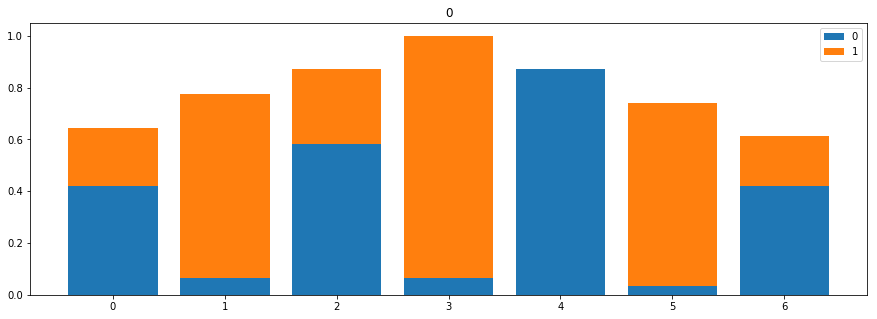

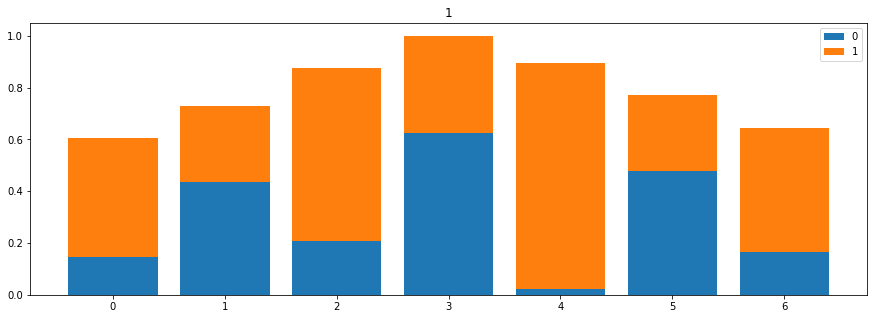

In [507]:
getPlotFrequencies(normalizedfqcy1d)

### 2D data

In [180]:
data = np.load("data/wildfire.npy")

In [494]:
radious = [3,3]
neighborhood = mooreWLevels(radious)
paddingType = 1
paddingValue = -1

In [495]:
problem = getLearningProblemWLevels(data,neighborhood,paddingType,paddingValue)

In [496]:
strlevels = strLevel(problem,3)
strlevelstbl = getTable(strlevels)

In [497]:
frequents = getTopFrequent(strlevelstbl,10)
uniques = getUniqueCount(strlevelstbl)

In [498]:
lvlclass = getLevelClass(strlevelstbl)
ambiguity = getNeighborhoodAmbiguity(lvlclass)

In [499]:
frequencypositions = getFrequencyByLocation(strlevelstbl,3)
normalizedfqcy =  normalizeFrequency(frequencypositions)

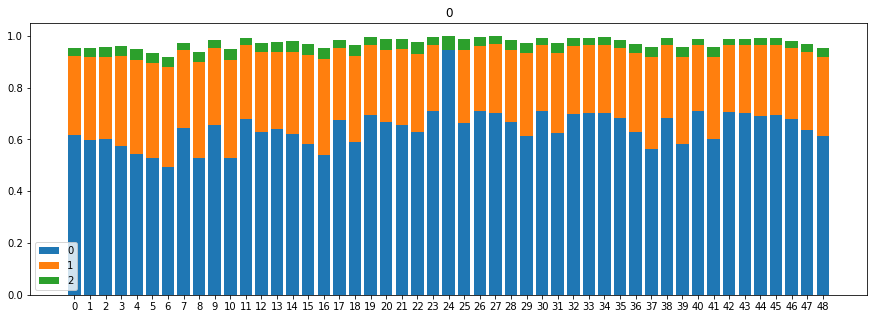

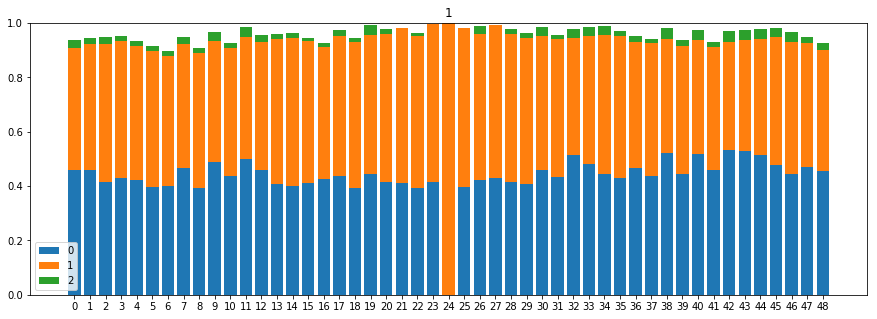

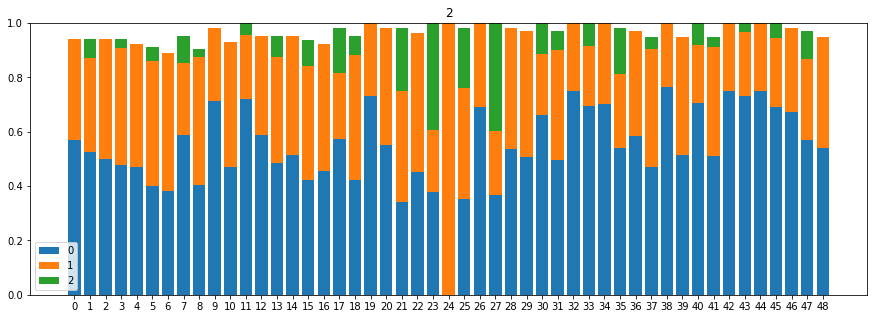

In [500]:
getPlotFrequencies(normalizedfqcy)

In [338]:
bdms = getBDM(strlevelstbl)

In [501]:
lvlclass

{'1': {'[0, 0, 0, 0, 0, 0, 0, 0, 0]': {0: 2486},
  '[0, 0, 1, 0, 0, 0, 0, 0, 0]': {0: 155},
  '[0, 0, 0, 0, 0, 0, 0, 0, 1]': {0: 134},
  '[0, 0, 2, 0, 0, 0, 0, 0, 0]': {0: 131},
  '[1, 0, 0, 0, 0, 0, 0, 0, 0]': {0: 114},
  '[0, 0, 0, 0, 0, 0, 1, 0, 0]': {0: 104},
  '[0, 1, 0, 0, 0, 0, 0, 0, 0]': {0: 88},
  '[0, 0, 0, 1, 0, 0, 0, 0, 0]': {0: 81},
  '[0, 0, 0, 0, 0, 1, 0, 0, 0]': {0: 72},
  '[0, 0, 0, 0, 0, 0, 0, 0, 2]': {0: 69},
  '[2, 0, 0, 0, 0, 0, 0, 0, 0]': {0: 69},
  '[0, 0, 1, 0, 0, 1, 0, 0, 0]': {0: 58},
  '[0, 0, 0, 0, 0, 0, 1, 1, 1]': {0: 54},
  '[0, 0, 0, 0, 0, 0, 0, 1, 0]': {0: 52},
  '[1, 0, 0, 0, 0, 0, 1, 0, 0]': {0: 50},
  '[0, 2, 0, 0, 0, 0, 0, 0, 0]': {0: 50},
  '[0, 1, 1, 0, 0, 0, 0, 0, 0]': {0: 47},
  '[1, 1, 0, 0, 0, 0, 0, 0, 0]': {0: 47},
  '[1, 0, 1, 0, 0, 0, 0, 0, 0]': {0: 46},
  '[0, 0, 0, 0, 0, 2, 0, 0, 0]': {0: 45},
  '[1, 1, 1, 1, 0, 1, 1, 1, 1]': {0: 44},
  '[0, 0, 0, 0, 0, 1, 0, 0, 1]': {0: 44},
  '[1, 1, 0, 1, 0, 1, 1, 1, 1]': {0: 43},
  '[1, 1, 1, 1, 0, 1, 

In [502]:
uniques

{0: {'1': 562, '2': 5043, '3': 9515},
 1: {'1': 232, '2': 2711, '3': 5523},
 2: {'1': 204, '2': 516, '3': 516}}

In [503]:
strlevelstbl[1]

{'1': [[[1, 1, 1, 1, 1, 1, 1, 1, 0], 71],
  [[1, 1, 1, 1, 1, 1, 1, 1, 1], 64],
  [[1, 1, 1, 0, 1, 1, 1, 1, 1], 64],
  [[1, 1, 1, 1, 1, 1, 1, 0, 1], 62],
  [[0, 1, 1, 1, 1, 0, 1, 1, 1], 59],
  [[0, 1, 1, 1, 1, 1, 0, 0, 1], 58],
  [[1, 1, 1, 1, 1, 1, 0, 1, 1], 56],
  [[1, 1, 1, 0, 1, 0, 0, 1, 1], 55],
  [[1, 1, 0, 1, 1, 1, 0, 1, 0], 55],
  [[1, 1, 1, 0, 1, 1, 1, 1, 0], 51],
  [[1, 1, 1, 1, 1, 1, 0, 1, 0], 48],
  [[1, 0, 1, 1, 1, 1, 1, 1, 1], 46],
  [[0, 1, 0, 1, 1, 1, 1, 1, 1], 46],
  [[1, 0, 1, 0, 1, 1, 1, 1, 1], 45],
  [[1, 1, 1, 1, 1, 0, 1, 1, 0], 44],
  [[0, 1, 1, 1, 1, 1, 1, 0, 1], 43],
  [[0, 1, 1, 1, 1, 1, 1, 1, 1], 43],
  [[1, 0, 1, 1, 1, 0, 0, 0, 0], 43],
  [[1, 0, 1, 1, 1, 1, 1, 1, 0], 42],
  [[0, 1, 1, 1, 1, 0, 0, 1, 0], 42],
  [[1, 0, 1, 1, 1, 1, 1, 0, 0], 41],
  [[1, 1, 0, 1, 1, 1, 1, 1, 1], 41],
  [[0, 1, 0, 0, 1, 1, 1, 0, 0], 41],
  [[1, 1, 1, 0, 1, 1, 0, 1, 0], 40],
  [[0, 0, 1, 1, 1, 1, 1, 1, 1], 40],
  [[1, 0, 1, 1, 1, 1, 1, 0, 1], 40],
  [[1, 1, 0, 1, 1, 1, 1, 0, 1], 4

In [504]:
frequents

{0: {'1': [[[0, 0, 0, 0, 0, 0, 0, 0, 0], 2486],
   [[0, 0, 1, 0, 0, 0, 0, 0, 0], 155],
   [[0, 0, 0, 0, 0, 0, 0, 0, 1], 134],
   [[0, 0, 2, 0, 0, 0, 0, 0, 0], 131],
   [[1, 0, 0, 0, 0, 0, 0, 0, 0], 114],
   [[0, 0, 0, 0, 0, 0, 1, 0, 0], 104],
   [[0, 1, 0, 0, 0, 0, 0, 0, 0], 88],
   [[0, 0, 0, 1, 0, 0, 0, 0, 0], 81],
   [[0, 0, 0, 0, 0, 1, 0, 0, 0], 72],
   [[0, 0, 0, 0, 0, 0, 0, 0, 2], 69]],
  '2': [[[0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0],
    529],
   [[0,
     0,
     0,
     0,
     2,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0],
    63],
   [[0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
  

In [304]:
strlevels[0]

{'1': {'[1, 1, 0, 1, 0, 0, 0, 0, 0]': [[1, 1, 0, 1, 0, 0, 0, 0, 0], 15],
  '[0, 0, 1, 1, 0, 1, 0, 0, 0]': [[0, 0, 1, 1, 0, 1, 0, 0, 0], 6],
  '[1, 1, 1, 1, 0, 1, 0, 0, 0]': [[1, 1, 1, 1, 0, 1, 0, 0, 0], 32],
  '[1, 0, 1, 1, 0, 1, 0, 0, 0]': [[1, 0, 1, 1, 0, 1, 0, 0, 0], 11],
  '[1, 1, 1, 0, 0, 1, 0, 0, 0]': [[1, 1, 1, 0, 0, 1, 0, 0, 0], 23],
  '[1, 1, 1, 1, 0, 0, 0, 0, 0]': [[1, 1, 1, 1, 0, 0, 0, 0, 0], 11],
  '[0, 1, 1, 1, 0, 1, 0, 0, 0]': [[0, 1, 1, 1, 0, 1, 0, 0, 0], 5],
  '[0, 1, 0, 1, 0, 1, 0, 0, 0]': [[0, 1, 0, 1, 0, 1, 0, 0, 0], 4],
  '[1, 1, 0, 1, 0, 1, 0, 0, 0]': [[1, 1, 0, 1, 0, 1, 0, 0, 0], 29],
  '[0, 0, 1, 0, 0, 1, 0, 0, 0]': [[0, 0, 1, 0, 0, 1, 0, 0, 0], 60],
  '[0, 0, 0, 0, 0, 0, 0, 0, 0]': [[0, 0, 0, 0, 0, 0, 0, 0, 0], 2504],
  '[0, 1, 0, 0, 0, 1, 1, 0, 1]': [[0, 1, 0, 0, 0, 1, 1, 0, 1], 3],
  '[1, 0, 1, 1, 0, 0, 1, 1, 0]': [[1, 0, 1, 1, 0, 0, 1, 1, 0], 20],
  '[0, 1, 0, 1, 0, 1, 1, 1, 1]': [[0, 1, 0, 1, 0, 1, 1, 1, 1], 36],
  '[1, 0, 0, 1, 0, 1, 1, 1, 1]': [[1, 0, 0, 1

## Process

### Load the data

In [58]:
dataframe = pd.read_csv("data/93.csv")

### Set parameters

In [40]:
radious = 6
percentage = .8
neighborhood = moore([radious])
paddingType = 1
paddingValue = 0

### Preprocessing

In [61]:
problem = getLearningProblem(dataframe.values,neighborhood,paddingType,paddingValue)
matrix = dictToMat(problem)
domain = getDomain(matrix)
binarized = binarize(matrix,domain)
posNeg = getPosNeg(domain,binarized)

In [ ]:
#learn a set of rules for each cell
problem2= getLearningProblem2(dataframe.values,neighborhood,paddingType,paddingValue)
matrix2 = dictToMat2(problem2)
rules = {}
domain2 = {}
binarized2 = {}
posNeg2 = {}
for key in matrix2:
    domain2[key] = getDomain(matrix2[key])
    binarized2[key] = binarize(matrix2[key],domain2[key])
    posNeg2[key] = getPosNeg(domain2[key],binarized2[key])

### Obtain the rules

In [ ]:
rules = getRules(posNeg,percentage=percentage)

In [ ]:
rules2 = {}
for key in posNeg2:
    rules2[key] = getRules(posNeg2[key],percentage=percentage)

### Transform the rules to the original space

In [ ]:
dRules = binarizedToDomain(rules,domain)

In [ ]:
dRules2 = {}
for key in rules2:
    dRules2[key] = binarizedToDomain(rules2[key],domain2[key])

### Simplification

In [ ]:
simplify1 = firstSimplification(rules,domain)
literals,literalsInv = getLiterals(simplify1)
clausules = getClausulesWithLiterals(simplify1,literals)
clausules = secondSimplification(clausules)
simplify2 = transformToOriginal(clausules,literalsInv)

In [ ]:
def getTruthTable(rules):
    tbls = {}
    literals,literalsInv = getLiterals(rules)
    clausules = getClausulesWithLiterals(rules,literals)
    for key in clausules:
        
    return clausules

In [ ]:
def getRuleSpace(noVar, domain):
    space = []
    count = noVar
    maxSize = len(domain) ** noVar
    #print(maxSize)
    while count > 0:
        no = (len(domain) ** count)
        repeatCount = int(no / len(domain))
        repeatCount2 = int(maxSize/no)
        temp = []
        for j in range(repeatCount2):
            for x in domain:
                for i in range(repeatCount):
                    temp.append(x)
        space.append(temp)
        count -= 1
    return space

In [ ]:
space = getRuleSpace(41,[0,1])
np.shape(space)

In [ ]:
simplify2

In [ ]:
getTruthTable(simplify2)

## Test rules

### Initialize parameters

In [ ]:
initialState=np.array([1,1,3,0,0,0,0,0],dtype=int)

### Discovered Rules

In [ ]:
evolutionObtainedRules = [initialState]
for i,gen in ruleTestingGenerator(dRules,neighborhood,initialState,19,np.shape(initialState),1,0):
    evolutionObtainedRules.append(gen)
plotCA(evolutionObtainedRules)

In [ ]:
evolutionObtainedRules = [initialState]
for i,gen in ruleTestingGenerator2(dRules2,neighborhood,initialState,19,np.shape(initialState),1,0):
    evolutionObtainedRules.append(gen)
plotCA(evolutionObtainedRules)
dRules2

### Simplification 1

In [ ]:
evolutionFirstSimplification = [initialState]
for i,gen in ruleTestingGenerator(simplify1,neighborhood,initialState,19,np.shape(initialState),1,0):
    evolutionFirstSimplification.append(gen)
plotCA(evolutionFirstSimplification)

### Second simplification

In [ ]:
evolutionSecondSimplification = [initialState]
for i,gen in ruleTestingGenerator(simplify2,neighborhood,initialState,19,np.shape(initialState),1,0):
    evolutionSecondSimplification.append(gen)
plotCA(evolutionSecondSimplification)

## GA-Nuggets example

### Load data

In [513]:
dataframe = pd.read_csv("data/2_square.csv")

### Set parameters

In [519]:
radious = 6
neighborhood = moore([radious])
paddingType = 1
paddingValue = 0
beta = 2
w1 = 1
w2 = 5
antMaxSize = 50
antMinSize = 3
population = 100
mutationRate = .05
crossprob = .5
noOffsprings = 2
noSteps = 100

### Preprocessing

In [520]:
problem = getLearningProblem(dataframe.values,neighborhood,paddingType,paddingValue)
matrix = dictToMat(problem)
domain = getDomain(matrix)
binarized = np.array(binarize(matrix,domain))
binDomain = getDomain(binarized)
goalAttr = list(binDomain.keys())[-1]
noEvents = calculateNoEvents([goalAttr],binDomain,binarized)

### Obtain the rules

In [521]:
fit,pop,fitnessHistory = ganuggets(population,noOffsprings,antMinSize,antMaxSize,beta,w1,w2,mutationRate,crossprob,binarized,binDomain,goalAttr,noEvents,-1,noSteps)


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


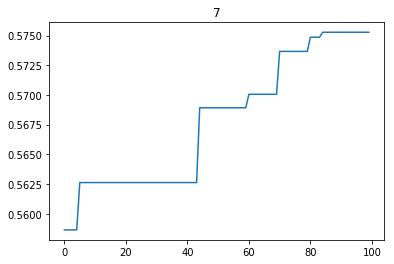

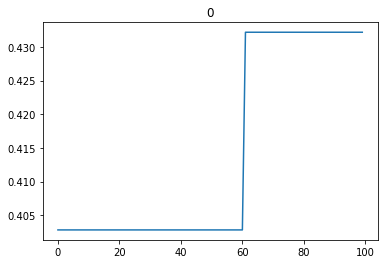

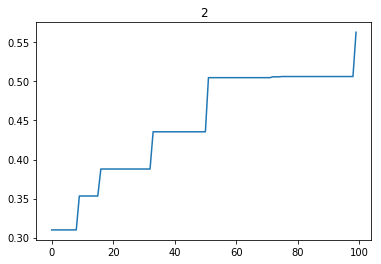

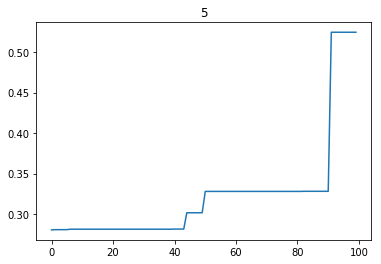

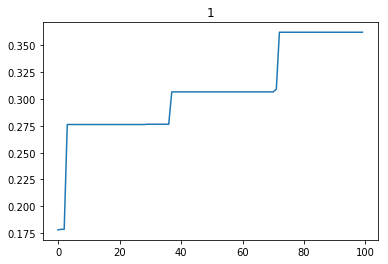

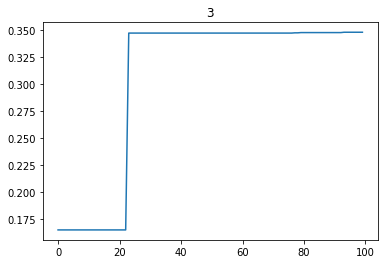

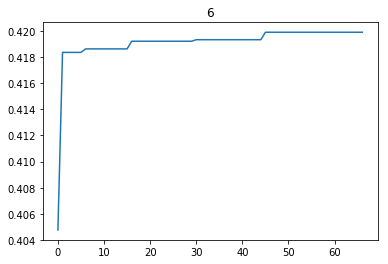

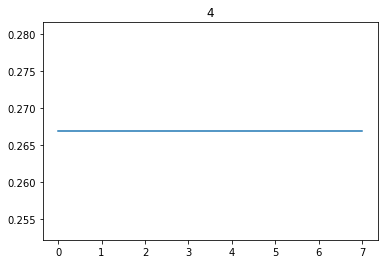

In [522]:
for key in fitnessHistory:
    plt.plot(range(len(fitnessHistory[key])),fitnessHistory[key])
    plt.title("{}".format(key))
    plt.show()

In [ ]:
bestInd = {}
for f in fit:
    if f[2] not in bestInd:
        bestInd[f[2]] = f
    if f[1] > bestInd[f[2]][1]:
        bestInd[f[2]] = f
bestPop = []
for key in bestInd:
    bestPop.append(pop[bestInd[key][0]])
rules = populationPostprocessing(bestPop)
dRules = binarizedToDomain(rules,domain)
print(bestInd)
dRules

In [ ]:
evolutionObtainedRules = [initialState]
for i,gen in ruleTestingGenerator(dRules,neighborhood,initialState,19,np.shape(initialState),1,0):
    evolutionObtainedRules.append(gen)
plotCA(evolutionObtainedRules)

## Lot processing

In [ ]:
dirName = "data/automatas/"
imgsDir = "data/automatas/images/"
seed = 150
if not os.path.exists(imgsDir):
    os.mkdir(imgsDir)
for file in os.listdir(dirName):
    if (".csv" in file) and not("control" in file):
        print(file)
        imgName = file.replace(".csv",".png")
        dataframe = pd.read_csv("{}/{}".format(dirName,file),header=None)
        fig = plotCA(dataframe.values,display=False)
        fig.savefig("{}original_{}".format(imgsDir,imgName))
        plt.close(fig)
        dataframe2 = pd.read_csv("{}/control_{}".format(dirName,file),header=None)
        fig = plotCA(dataframe2.values,display=False)
        fig.savefig("{}control_{}".format(imgsDir,imgName))
        plt.close(fig)
        radious = 10
        neighbors = getNeighbors(dataframe,radious)
        problem = getClassState(neighbors)
        matrix = dictToMat(problem)
        domain = getDomain(matrix)
        binarized = binarize(matrix)
        posNeg = getPosNeg(domain,binarized)
        rules = getRules(posNeg,percentage=.6,seed=seed)
        if rules == None:
            continue
        dRules = binarizedToDomain(rules,domain)
        initState = dataframe.values[0]
        res = testRulesOneDimension(initState,radious,30,dRules)
        fig = plotCA(res["history"],display = False)
        fig.savefig("{}learned_{}".format(imgsDir,imgName))
        plt.close(fig)
        res = testRulesOneDimension([0,0,1,0,1,1,0,0,1,0],radious,30,dRules)
        fig = plotCA(res["history"],display = False)
        fig.savefig("{}modified_{}".format(imgsDir,imgName))
        plt.close(fig)

In [ ]:
rule = 30
original = Image.open("{}original_{}.png".format(imgsDir,rule))
learned = Image.open("{}learned_{}.png".format(imgsDir,rule))
fig, axs = plt.subplots(1, 2,figsize=(10,10))
axs[0].imshow(original)
axs[0].set_xlim(600, 900)
axs[0].set_ylim(650, 50)
axs[0].set_title("Original")
axs[1].imshow(learned)
axs[1].set_xlim(600, 900)
axs[1].set_ylim(650, 50)
axs[1].set_title("Learned")

In [ ]:
control = Image.open("{}control_{}.png".format(imgsDir,rule))
modified = Image.open("{}modified_{}.png".format(imgsDir,rule))
fig, axs = plt.subplots(1, 2,figsize=(10,10))
axs[0].imshow(control)
axs[0].set_xlim(600, 900)
axs[0].set_ylim(650, 50)
axs[0].set_title("Control")
axs[1].imshow(modified)
axs[1].set_xlim(600, 900)
axs[1].set_ylim(650, 50)
axs[1].set_title("Modified")

# 2d Experiments

## Experiment Functions

In [ ]:
def setup(savePath):
    if not os.path.exists(savePath):
        os.mkdir(savePath)
        print("creating path: {}".format(savePath))
        return True
    else:
        return False

def createAutomata(dimension,radious,neighbourhood,rule,k,timesteps):
    cellular_automaton = cpl.init_random2d(*dimension,k)
    cellular_automaton = cpl.evolve2d(cellular_automaton, timesteps=timesteps, neighbourhood=neighbourhood,
                                      apply_rule=lambda n, c, t: cpl.totalistic_rule(n, k=k, rule=rule))
    return cellular_automaton

def preprocessing(data,neighborhood,paddingType,paddingValue):
    problem = getLearningProblem(data,neighborhood,paddingType,paddingValue)
    print(np.shape(problem))
    matrix = dictToMat(problem)
    print(np.shape(matrix))
    domain = getDomain(matrix)
    binarized = binarize(matrix,domain)
    posNeg = getPosNeg(domain,binarized)
    return posNeg,domain
    
def learning(posNeg,percentage,top,seed):
    rules = getRules(posNeg,percentage=percentage,top=top,seed=seed)
    return rules

def originalSpace(rules,domain):
    dRules = binarizedToDomain(rules,domain)
    return dRules

def simplification1(rules,domain):
    simplify1 = firstSimplification(rules,domain)
    return simplify1

def simplification2(simplify1):
    literals,literalsInv = getLiterals(simplify1)
    clausules = getClausulesWithLiterals(simplify1,literals)
    clausules = secondSimplification(clausules)
    simplify2 = transformToOriginal(clausules,literalsInv)
    return simplify2

def testing(initialState,rules,neighborhood,dimension,iterations,paddingType,paddingValue):
    evolution = np.array([initialState])
    for i,gen in ruleTestingGenerator(rules,neighborhood,initialState,iterations-1,np.shape(initialState),paddingType,paddingValue):
        evolution = np.append(evolution,gen)
    return evolution.reshape([iterations]+dimension)
    

In [ ]:
def preprocessing2(data,neighborhood,paddingType,paddingValue):
    #learn a set of rules for each cell
    domain2 = {}
    binarized2 = {}
    posNeg2 = {}
    problem2= getLearningProblem2(data,neighborhood,paddingType,paddingValue)
    matrix2 = dictToMat2(problem2)
    for key in matrix2:
        domain2[key] = getDomain(matrix2[key])
        binarized2[key] = binarize(matrix2[key],domain2[key])
        posNeg2[key] = getPosNeg(domain2[key],binarized2[key])
    return posNeg2,domain2,problem2
    
def learning2(posNeg,percentage,top,seed):
    rules2 = {}
    for key in posNeg:
        rules2[key] = getRules(posNeg[key],percentage=percentage)
    return rules2

def originalSpace2(rules,domain):
    dRules2 = {}
    for key in rules:
        dRules2[key] = binarizedToDomain(rules[key],domain[key])
    return dRules2

def testing2(initialState,rules,neighborhood,dimension,iterations,paddingType,paddingValue):
    evolution = np.array([initialState])
    for i,gen in ruleTestingGenerator2(rules,neighborhood,initialState,iterations-1,np.shape(initialState),paddingType,paddingValue):
        evolution = np.append(evolution,gen)
    return evolution.reshape([iterations]+dimension)

In [ ]:
def saveConfigurations(configPath,seed,neighborhoodTypes,radiousOriginal,radious,dimension,rule,k,timesteps,neighborhoodType,percentage,top,paddingValue,paddingType):
    config = {}
    config["neighborhoodTypes"] = neighborhoodTypes
    config["radiousOriginal"] = radiousOriginal
    config["radious"] = radious
    config["dimension"] = dimension
    config["rule"] = rule
    config["k"] = k
    config["seed"] = seed
    config["timesteps"] = timesteps
    config["neighborhoodType"] = neighborhoodType
    config["percentage"] = percentage
    config["top"] = top
    config["paddingValue"] = paddingValue
    config["paddingType"] = paddingType
    with open(configPath, "w") as write_file:
        json.dump(config, write_file)
    
def saveResults(savePath,data,test1,test2,test3,rules,dRules,simplify1,simplify2):
    np.save("{}/original.npy".format(savePath),data)
    np.save("{}/test1.npy".format(savePath),test1)
    np.save("{}/test2.npy".format(savePath),test2)
    np.save("{}/test3.npy".format(savePath),test3)
    rulesFile = {}
    rulesFile["original"] = str(rules)
    rulesFile["dRules"] = str(dRules)
    rulesFile["simplify1"] = str(simplify1)
    rulesFile["simplify2"] = str(simplify2)
    rulesPath = "{}/rules.json".format(savePath)
    with open(rulesPath, "w") as write_file:
        json.dump(rulesFile, write_file)
    

## Experiment parameters

### Setup

In [ ]:
neighborhoodTypes = {1:"Moore",2:"von Neumann"}
radiousOriginal = 1
radious = [1,1]
dimension = [50,50]
rule = 126
k= 3
timesteps = 50
neighborhoodType = 1
percentage = -1#.7
top = 10
if neighborhoodType == 1:
    neighborhood = moore(radious)
else:
    neighborhood = vonNeumann(radious[0])
paddingType = 1
paddingValue = 0
seed = -1#random.randint(0,100000000)
initialState = [] #testing
dt = datetime.now()
dateStr = dt.strftime("%d_%m_%y_%H_%M_%S")
radiousStr = "_".join([str(x) for x in radious])
dataPath = "data/wildfire.npy"
experimentName = "{}_{}_r{}_{}".format(neighborhoodTypes[neighborhoodType],radiousStr,rule,dateStr)
basePath = "data/2d_automatas"
savePath = "{}/{}".format(basePath,experimentName)
configPath = "{}/config.json".format(savePath)

## Run Experiment

In [ ]:
if setup(savePath):
    saveConfigurations(configPath,seed,neighborhoodTypes,radiousOriginal,radious,dimension,rule,k,timesteps,neighborhoodType,percentage,top,paddingValue,paddingType)
    if len(dataPath) > 0:
        data = np.load("data/wildfire.npy")
        #data = data[:10]
    else:
        data = createAutomata(dimension,radiousOriginal,neighborhoodTypes[neighborhoodType],rule,k,timesteps)
    posNeg,domain,problem2 = preprocessing2(data[:20],neighborhood,paddingType,paddingValue)
    rules = learning2(posNeg,percentage,top,seed)
    dRules = originalSpace2(rules,domain)
    simplify1 = ""#simplification1(rules,domain)
    simplify2 = ""#simplification2(simplify1)
    initialState = data[0]
    test1 = testing2(initialState,dRules,neighborhood,dimension,timesteps,paddingType,paddingValue)
    test2 = []#testing(initialState,simplify1,neighborhood,dimension,timesteps,paddingType,paddingValue)
    test3 = []#testing(initialState,simplify2,neighborhood,dimension,timesteps,paddingType,paddingValue)
    saveResults(savePath,data,test1,test2,test3,rules,dRules,simplify1,simplify2)
else:
    print("experiment already runned, run setup again")

In [ ]:
animate(test1,newcmp)

In [ ]:
animate(data)

In [ ]:
dirName = "data/2d_automatas/"
for folder in os.listdir(dirName):
    if ("moore" in folder) or ("von" in folder):
        with open("{}{}/config.json".format(dirName,folder), "r") as read_file:
            config = json.load(read_file)
        kernel = config["kernel"]
        dimension = config["dimension"]
        paddingType = config["paddingType"]
        paddingValue = config["paddingValue"]
        steps = config["steps"]
        problem = {}
        for step in range(1,steps):
            dataframe = pd.read_csv("{}/{}/{}.csv".format(dirName,folder,step),header=None)
            classDomain = dataframe[0].unique()
            for cls in classDomain:
                if cls not in problem:
                    problem[cls] = {}
                valuesFromClass = dataframe[dataframe[9] == cls].values
                for row in valuesFromClass:
                    r = row[:-1]
                    if str(r) not in problem[cls]:
                        problem[cls][str(r)] = r
        matrix = dictToMat(problem)
        domain = getDomain(matrix)
        binarized = binarize(matrix)
        posNeg = getPosNeg(domain,binarized)
        rules = getRules(posNeg,.5)
        dRules = binarizedToDomain(rules,domain)
        print(dRules)

In [ ]:
initialState = dataframe = pd.read_csv("{}/{}/{}.csv".format(dirName,folder,"step_0"),header=None)
initialState.values

In [ ]:
#ruleTesting(rules,neigborhood,initialState,noSteps,size,paddingType,paddingValue)
gen = ruleTestingGenerator(dRules,kernel,initialState.values,50,np.shape(initialState.values),1,0)

In [ ]:
evolution = []
for i,step in gen:
    print("step {}".format(i))
    evolution.append(step)
    plotCA(evolution[i].reshape((60,60)))

In [ ]:
dirName = "data/2d_automatas/126_moore/images"
if not os.path.exists(dirName):
    os.mkdir(dirName)
for i,step in enumerate(evolution):
    fig = plotCA(evolution[i].reshape((60,60)),display = False)
    fig.savefig("{}learned_{}.png".format(dirName,i))

In [ ]:
evolution = np.array(evolution)
evo2 = evolution.reshape((len(evolution),60,60))
animate(evo2)

In [ ]:
[5]+[6,7]

In [ ]:
wildfire = np.load("data/wildfire.npy")

In [ ]:
#exampleAnimation = animate(wildfire[:30],newcmp)
#exampleAnimation.save("exampleData.mp4",fps=3)
totalAnimation = animate(wildfire,newcmp)
#totalAnimation.save("allData2.mp4",fps=3)

In [ ]:
dimension = [50,50]
test1 = testing(initialState,dRules,neighborhood,dimension,timesteps,paddingType,paddingValue)
test2 = testing(initialState,simplify1,neighborhood,dimension,timesteps,paddingType,paddingValue)
test3 = testing(initialState,simplify2,neighborhood,dimension,timesteps,paddingType,paddingValue)
saveResults(savePath,data,test1,test2,test3,rules,dRules,simplify1,simplify2)

In [ ]:
test1Animation = animate(test1,newcmp)
test1Animation.save("test1Animation.mp4",fps=3)
test2Animation = animate(test2,newcmp)
test2Animation.save("test2Animation.mp4",fps=3)
test3Animation = animate(test3,newcmp)
test3Animation.save("test3Animation.mp4",fps=3)

In [ ]:
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
viridis = cm.get_cmap('viridis', 256)
newcolors = viridis(np.linspace(0, 1, 3))
brown = np.array([73/256, 56/256, 41/256, 1])
green = np.array([102/256, 141/256, 60/256, 1])
red = np.array([200/256, 59/256, 27/256, 1])
newcolors[:1, :] = brown
newcolors[1:2, :] = green
newcolors[2:3, :] = red
newcmp = ListedColormap(newcolors)


def plot_examples(cms):
    """
    helper function to plot two colormaps
    """
    np.random.seed(19680801)
    data = np.random.randn(30, 30)

    fig, axs = plt.subplots(1, 2, figsize=(6, 3), constrained_layout=True)
    for [ax, cmap] in zip(axs, cms):
        psm = ax.pcolormesh(data, cmap=cmap, rasterized=True, vmin=0, vmax=2)
        fig.colorbar(psm, ax=ax)
    plt.show()

plot_examples([viridis, newcmp])

In [ ]:
newcolors = viridis(np.linspace(0, 1, 4))
brown = np.array([73/256, 56/256, 41/256, 1])
green = np.array([102/256, 141/256, 60/256, 1])
red = np.array([200/256, 59/256, 27/256, 1])
blue = np.array([240/256, 240/256, 0/256, 1])
newcolors[:1, :] = brown
newcolors[1:2, :] = green
newcolors[2:3, :] = red
newcolors[3:4, :] = blue
newcmp2 = ListedColormap(newcolors)
plot_examples([newcmp, newcmp2])

In [ ]:
size = np.shape(test1)
error = np.zeros(shape= size)
for index in multiDimensionalGenerator(size):
    index = tuple(index)
    error[index] = wildfire[index] if test1[index] == wildfire[index] else 4
errorAnimation = animate(error,newcmp2)
errorAnimation.save("errorAnimation.mp4",fps=3)

In [ ]:
imgsDir = "wildfire_images"
if not os.path.exists(imgsDir):
    os.mkdir(imgsDir)
for i,step in enumerate(wildfire):
    fig = plotCA(step,display = False)
    fig.savefig("{}/step_{}".format(imgsDir,i))